# Training a PINN using a combination of data and physics loss

In [76]:
from pathlib import Path
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from itertools import product
from tqdm.auto import tqdm


# Add src folder to Python path
sys.path.append(str(Path("../src").resolve()))

from data_generation import generate_data
from ode_model import LorenzModel
from lstm import WindowedTimeSeries, train_model, predict_autoregressive, evaluate_model

In [77]:
n = 10000
noise_level = 0.05
assim_noise_level=0.01
obs_increment = 0.05

obs_data = generate_data(n, noise_level=noise_level, time_step=obs_increment)
assimilated_data = generate_data(n, noise_level=assim_noise_level, time_step=obs_increment)

In [20]:
c=13
k=10
ode_model = LorenzModel(c=13, t_step=k*obs_increment)

In [78]:
train_length = int(obs_data.shape[0] * 0.8)
val_length = int(obs_data.shape[0] * 0.9)
train_obs_series = obs_data[:train_length, :]
val_obs_series = obs_data[train_length:val_length, :]
test_obs_series = obs_data[val_length:, :]
train_assim_series = assimilated_data[:train_length, :]

In [21]:
train_dataset = WindowedTimeSeries(input_series=train_obs_series, assim_series=train_assim_series, seq_length=10, horizon=k)
val_dataset = WindowedTimeSeries(input_series=val_obs_series, seq_length=10, horizon=k)
test_dataset = WindowedTimeSeries(input_series=test_obs_series, seq_length=10, horizon=k)


In [22]:
lstm_model = train_model(
  train_dataset=train_dataset,
  val_dataset=val_dataset,
  hidden_size=100,
  num_layers=1,
  batch_size=256,
  learning_rate=0.01,
  num_epochs=100,
  patience=20,
  device=torch.device("cpu"),
  physics_model=ode_model,
  lambda_phys=0.5
)

Epoch [10/100], train_loss: 61.3801, val_loss: 35.9200
Epoch [20/100], train_loss: 28.3060, val_loss: 18.6894
Epoch [30/100], train_loss: 23.0393, val_loss: 14.1802
Epoch [40/100], train_loss: 22.1019, val_loss: 13.6039
Epoch [50/100], train_loss: 20.8103, val_loss: 13.6725
Epoch [60/100], train_loss: 20.0778, val_loss: 12.9475
Epoch [70/100], train_loss: 18.9511, val_loss: 12.0551
Epoch [80/100], train_loss: 19.2596, val_loss: 12.9473
Epoch [90/100], train_loss: 18.7618, val_loss: 12.3038
Epoch [100/100], train_loss: 18.1634, val_loss: 13.2297


In [23]:
evaluate_model(lstm_model, test_dataset)

7.77947998046875

In [89]:
c_range = np.linspace(11,16,11)
k_range = np.arange(1,21)
lambda_range = 0.1
configs = list(product(k_range, c_range))

In [90]:
ds = xr.Dataset(
    {
        "mse": (("k", "c"),
                np.full((len(k_range), len(c_range)), np.nan))
    },
    coords={
        "k": k_range,
        "c": c_range,
    }
)

In [91]:
pbar = tqdm(configs, desc="Hyperparameter Sweep", colour="green")

for k, c in pbar:
  ode_model.update_params(c=c, t_step=k*obs_increment)

  train_dataset = WindowedTimeSeries(input_series=train_obs_series, assim_series=train_assim_series, seq_length=10, horizon=k)
  val_dataset = WindowedTimeSeries(input_series=val_obs_series, seq_length=10, horizon=k)
  test_dataset = WindowedTimeSeries(input_series=test_obs_series, seq_length=10, horizon=k)
    
  lstm_model = train_model(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    hidden_size=100,
    num_layers=1,
    batch_size=256,
    learning_rate=0.01,
    num_epochs=100,
    patience=20,
    device=torch.device("mps"),
    physics_model=ode_model,
    lambda_phys=0.1,
    silence=True
  )

  mse = evaluate_model(lstm_model, test_dataset)
  ds["mse"].loc[dict(k=k, c=c)] = mse

  pbar.set_postfix(mse=f"{mse:.2f}", k=k, c=c)


Hyperparameter Sweep:   0%|          | 0/220 [00:00<?, ?it/s]

In [101]:
out_path = Path("../data/processed/mse_PINN.nc")

ds.attrs["patience"] = 20
ds.attrs["epochs"] = 100
ds.attrs["lambda_phys"] = 0.1

ds.to_netcdf(out_path)

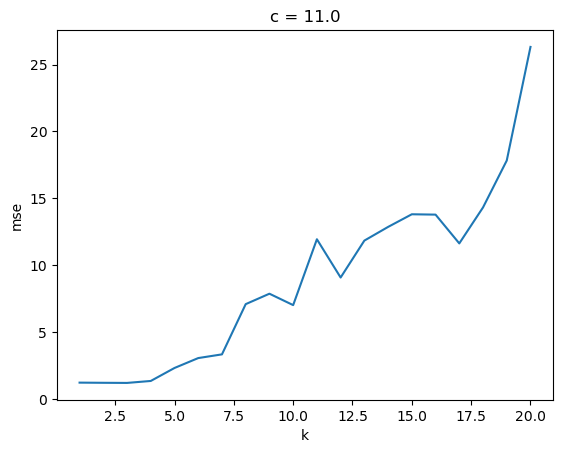

In [99]:
ds["mse"].sel(c=11).plot()


In [24]:
for lambda_phys in [0, 0.1, 0.2, 0.3]:
  ode_model.update_params(c=16, t_step=10*obs_increment)

  train_dataset = WindowedTimeSeries(input_series=train_obs_series, assim_series=train_assim_series, seq_length=10, horizon=10)
  val_dataset = WindowedTimeSeries(input_series=val_obs_series, seq_length=10, horizon=10)
  test_dataset = WindowedTimeSeries(input_series=test_obs_series, seq_length=10, horizon=10)
    
  lstm_model = train_model(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    hidden_size=100,
    num_layers=1,
    batch_size=256,
    learning_rate=0.01,
    num_epochs=200,
    patience=20,
    device=torch.device("mps"),
    physics_model=ode_model,
    lambda_phys=lambda_phys,
    silence=True
  )

  mse = evaluate_model(lstm_model, test_dataset)
  print(f"lambda: {lambda_phys}, mse:{mse}")

lambda: 0, mse:9.955208778381348
lambda: 0.1, mse:6.868438720703125
lambda: 0.2, mse:8.579585075378418
lambda: 0.3, mse:7.14365291595459


In [5]:
ds_pinn = xr.open_dataset("../data/processed/mse_PINN_intial.nc")

In [73]:
ds_pinn["mse"]

<xarray.DataArray 'mse' (k: 6, c: 6, lambda_phys: 4)> Size: 1kB
[144 values with dtype=float64]
Coordinates:
  * k            (k) int32 24B 1 2 3 4 5 10
  * c            (c) float64 48B 11.0 12.0 13.0 14.0 15.0 16.0
  * lambda_phys  (lambda_phys) float64 32B 0.0 0.1 0.2 0.5